# **Hands On Graph Neural Networks Using Python  -  CHAPTER 15**

This script implements a temporal `graph neural network (GNN) model` to predict traffic speeds using spatio-temporal data. It involves three main components: data preparation, model training, and evaluation.

- First, the `DataPreparation` class loads traffic speed and distance data, computes an adjacency matrix based on the distances between sensors, and plots various visualizations.

- The `TemporalGNN` class defines a temporal GNN model using the A3TGCN layer to process time series data from multiple sensors.

- The `ModelTraining` class handles model training and evaluation, computing performance metrics like MAE, RMSE, and MAPE.

The script's main function prepares the data, sets up the model, and trains it using a dataset created from the traffic data. After training, the model is evaluated to predict future traffic speeds based on historical data.

In [40]:
# !pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install -q torch-geometric-temporal==0.54.0

import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric_temporal.nn.recurrent import A3TGCN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split

### **Data Preparation Class**

This class is responsible for loading and preparing `traffic data` from CSV files. It includes methods to visualize traffic speed data, compute statistical summaries (mean and standard deviation), plot correlation and distance matrices, and generate the adjacency matrix based on sensor distances. Additionally, it can visualize the adjacency matrix and plot the corresponding sensor graph.

In [21]:
class DataPreparation:
    def __init__(self, speed_file, distance_file):
        self.speeds = pd.read_csv(speed_file, names=range(0, 228))
        self.distances = pd.read_csv(distance_file, names=range(0, 228))
        self.adj = None

    def plot_speed_data(self):
        plt.figure(figsize=(10, 5), dpi=100)
        plt.plot(self.speeds)
        plt.grid(linestyle=':')
        plt.xlabel('Time (5 min)')
        plt.ylabel('Traffic speed')
        plt.show()

    def plot_mean_std_speed(self):
        mean = self.speeds.mean(axis=1)
        std = self.speeds.std(axis=1)

        plt.figure(figsize=(10, 5), dpi=100)
        plt.plot(mean, 'k-')
        plt.grid(linestyle=':')
        plt.fill_between(mean.index, mean - std, mean + std, color='r', alpha=0.1)
        plt.xlabel('Time (5 min)')
        plt.ylabel('Traffic speed')
        plt.show()

    def plot_correlation_matrices(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        fig.tight_layout(pad=3.0)
        ax1.matshow(self.distances)
        ax1.set_xlabel("Sensor station")
        ax1.set_ylabel("Sensor station")
        ax1.title.set_text("Distance matrix")
        ax2.matshow(-np.corrcoef(self.speeds.T))
        ax2.set_xlabel("Sensor station")
        ax2.set_ylabel("Sensor station")
        ax2.title.set_text("Correlation matrix")
        plt.show()

    def compute_adj(self, sigma2=0.1, epsilon=0.5):
        d = self.distances.to_numpy() / 10000.0
        d2 = d * d
        n = self.distances.shape[0]
        w_mask = np.ones([n, n]) - np.identity(n)
        self.adj = np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask

    def plot_adj_matrix(self):
        plt.figure(figsize=(8, 8))
        plt.matshow(self.adj, False)
        plt.colorbar()
        plt.xlabel("Sensor station")
        plt.ylabel("Sensor station")
        plt.show()

    def plot_graph(self):
        rows, cols = np.where(self.adj > 0)
        edges = zip(rows.tolist(), cols.tolist())
        G = nx.Graph()
        G.add_edges_from(edges)
        plt.figure(figsize=(10, 5))
        nx.draw(G, with_labels=True)
        plt.show()

### **Temporal GNN Model Class**

This class defines a temporal graph neural network model using the `A3TGCN layer`. The model takes as input the graph's temporal signals (sensor data over time) and outputs traffic speed predictions. It consists of a temporal `GCN layer` followed by a linear layer to generate predictions.

In [22]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, out_channels=32, periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

### **Model Training Class**

This class manages the training and evaluation of the temporal `GNN model`. It handles the training loop, calculating the loss, and performing optimization. It also includes an evaluation method that tests the model's predictions and computes metrics such as `MAE`, `RMSE`, and `MAPE`. Additionally, it has utility functions for inverse z-score normalization and error metric calculations to compare predicted and actual traffic speeds.

In [23]:
class ModelTraining:
    def __init__(self, model, train_dataset, test_dataset, optimizer, lags, speeds):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.optimizer = optimizer
        self.lags = lags
        self.speeds = speeds

    def train(self, epochs=30):
        self.model.train()
        for epoch in range(epochs):
            loss = 0
            step = 0
            for snapshot in self.train_dataset:
                y_pred = self.model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
                loss += torch.mean((y_pred - snapshot.y) ** 2)
                step += 1
            loss = loss / (step + 1)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            if epoch % 5 == 0:
                print(f"Epoch {epoch:>2} | Train MSE: {loss:.4f}")

    def evaluate(self):
        self.model.eval()
        y_test = []
        gnn_pred = []
        for snapshot in self.test_dataset:
            y_hat = snapshot.y.numpy()
            y_hat = self.inverse_zscore(y_hat, self.speeds.mean(axis=0), self.speeds.std(axis=0))
            y_test = np.append(y_test, y_hat)

            y_hat = self.model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy()
            y_hat = self.inverse_zscore(y_hat, self.speeds.mean(axis=0), self.speeds.std(axis=0))
            gnn_pred = np.append(gnn_pred, y_hat)

        print(f'GNN MAE  = {self.MAE(gnn_pred, y_test):.4f}')
        print(f'GNN RMSE = {self.RMSE(gnn_pred, y_test):.4f}')
        print(f'GNN MAPE = {self.MAPE(gnn_pred, y_test):.4f}')

    @staticmethod
    def inverse_zscore(x, mean, std):
        return x * std + mean

    @staticmethod
    def MAE(real, pred):
        return np.mean(np.abs(pred - real))

    @staticmethod
    def RMSE(real, pred):
        return np.sqrt(np.mean((pred - real) ** 2))

    @staticmethod
    def MAPE(real, pred):
        return np.mean(np.abs(pred - real) / (real + 1e-5))

### **Data Preparation**

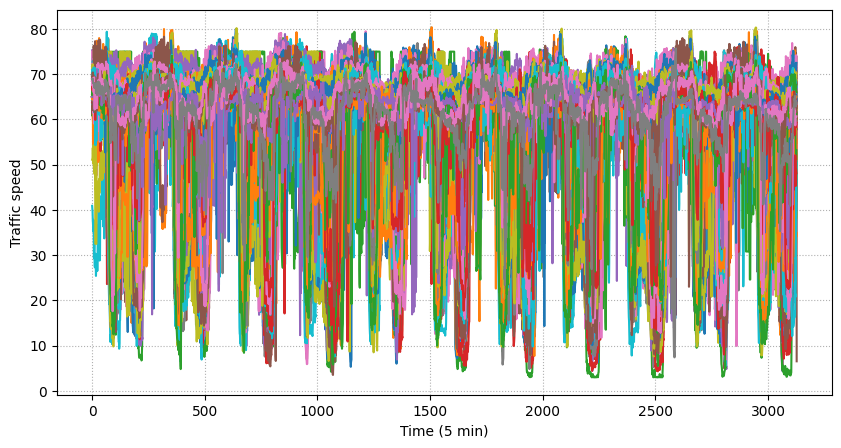

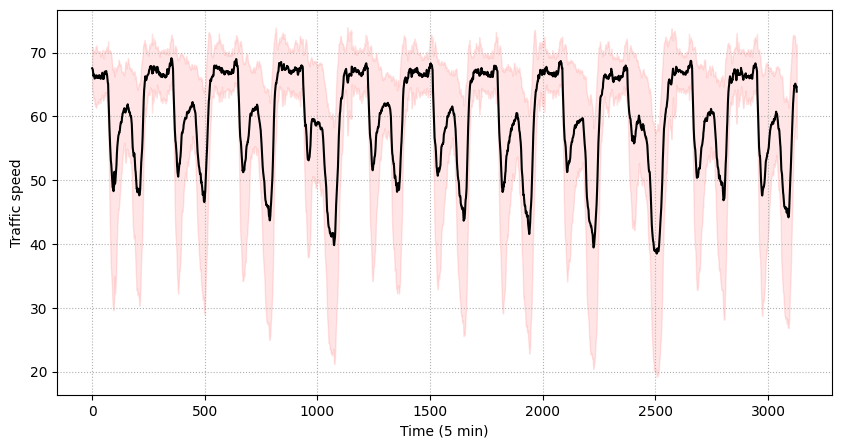

In [30]:
data_prep = DataPreparation('PeMSD7_V_228.csv', 'PeMSD7_W_228.csv')
data_prep.plot_speed_data()
print("\n\n")
data_prep.plot_mean_std_speed()

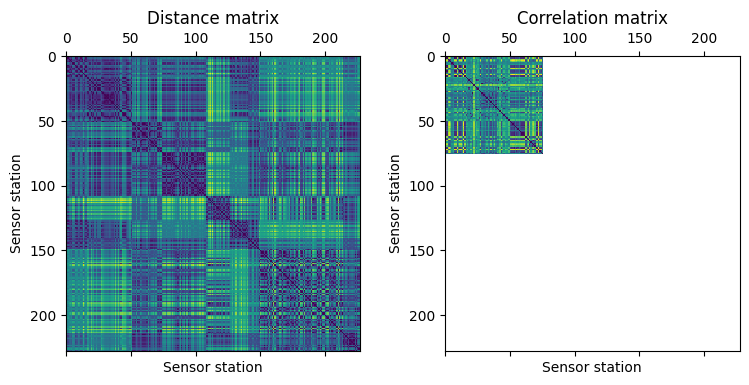

In [28]:
data_prep.plot_correlation_matrices()
data_prep.compute_adj()

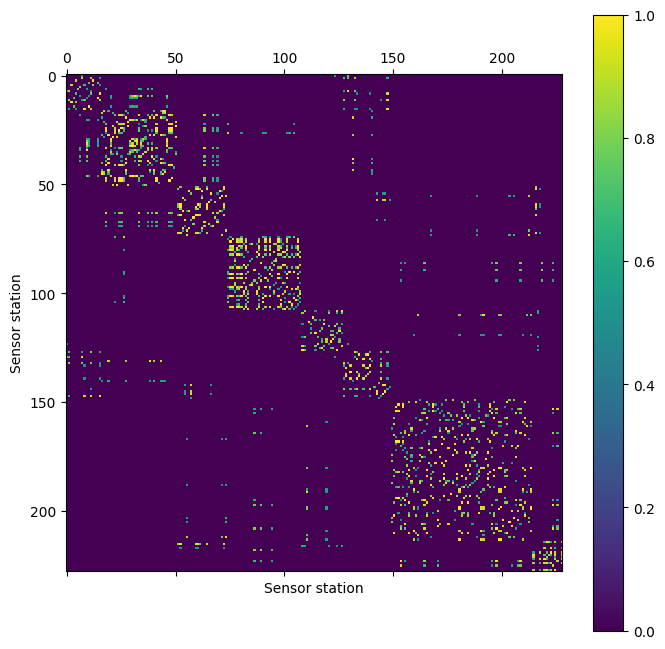

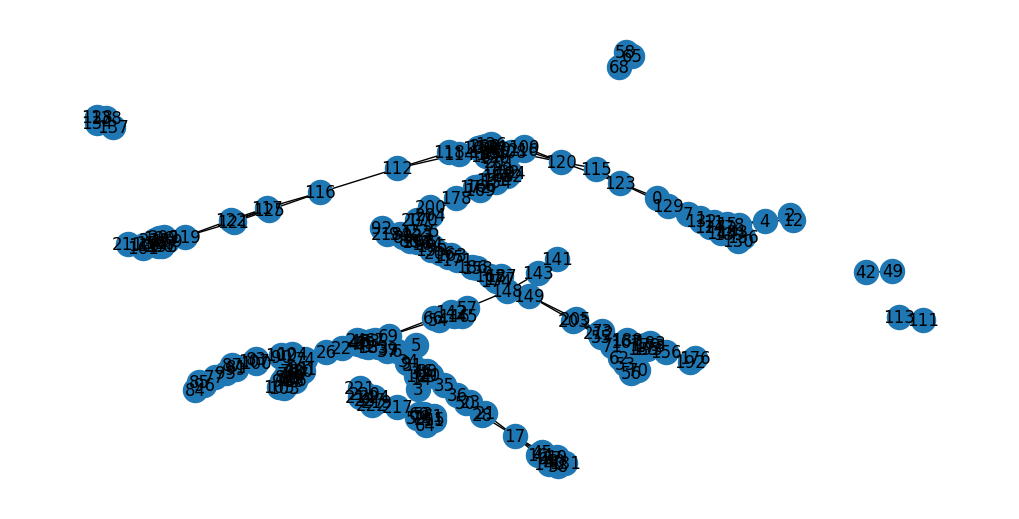

In [29]:
data_prep.plot_adj_matrix()
print("\n\n")
data_prep.plot_graph()

### **Create Dataset**

### **Model Setup**

In [49]:
lags = 24
horizon = 48
model = TemporalGNN(lags, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(24, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(24, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(24, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


### **Train The Model**

In [33]:
trainer = ModelTraining(model, train_dataset, test_dataset, optimizer, lags, data_prep.speeds)
trainer.train(epochs=30)

Epoch  0 | Train MSE: 1.0373
Epoch  5 | Train MSE: 1.0084
Epoch 10 | Train MSE: 0.9889
Epoch 15 | Train MSE: 0.9677
Epoch 20 | Train MSE: 0.9416
Epoch 25 | Train MSE: 0.9154


### **Evaluate The Model**

In [34]:
trainer.evaluate()

GNN MAE  = 8.2412
GNN RMSE = 11.9689
GNN MAPE = 0.1440
